***Parameter Definitions***

In [57]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 1                            # Number of Patterns
dd_factor               = 1                            # Detector Downsampling Factor

Load object

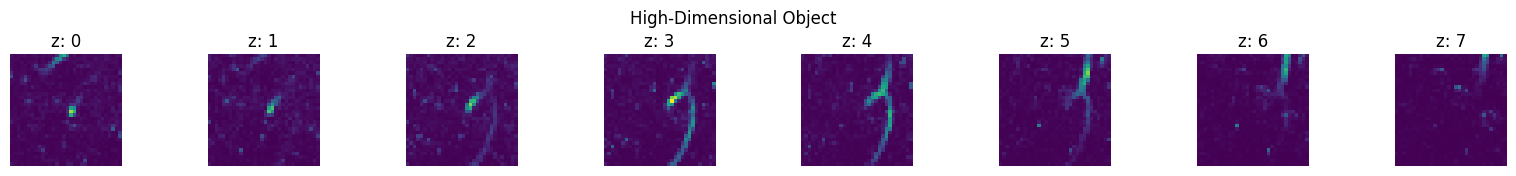

In [14]:
from libs.forward_lib.read_data import ReadData

RD = ReadData(nx, ny, nz, up_factor=0.25)
RD.load_object("blood_cell")
RD.visualize_data(is_orginal=True, n_planes=8)

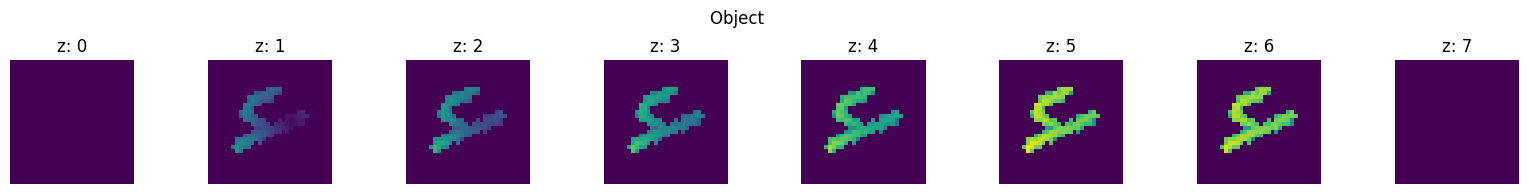

In [19]:
from libs.forward_lib.simulate_data import MnistSimulator

MS = MnistSimulator(nx, ny, nz, up_factor=(6/28,1,1))
MS.update_data()
MS.visualize_object(vis_planes=True)

Linearized Model

In [58]:
from libs.forward_lib.linearized_process_D2NN import LinearizedModel

LM = LinearizedModel(nx, ny, nz, m, dd_factor, n_planes=1)
LM.init_models()
print(LM)

LM.find_transformation()
# LM.visualize_A()

FM = LM.A.cpu().numpy()

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
D2NN Patterns 			: 1
# of Plane			: 1
Detector Pool size 		: 1×1
Computational Device 		: cpu




Pattern: 1/1	 Nz: 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


In [63]:
import numpy as np

X = RD.X.cpu().numpy().reshape(nx*ny*nz, 1)
y_clean = FM@X

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(m*(nx//dd_factor)*(ny//dd_factor), 1)

Run twist


Initial objective = 6605.707549551559, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Iteration = 2, objective = 1261.9779197606695, nz = 8192, criterion = 80.89564349777578
Iteration = 3, objective = 495.8482437141243, nz = 8192, criterion = 60.70864347546109
Iteration = 4, objective = 305.01144262284697, nz = 8192, criterion = 38.48693698334487
Iteration = 5, objective = 181.06389548229524, nz = 8192, criterion = 40.63701547545397
Iteration = 6, objective = 163.99079584803053, nz = 8192, criterion = 9.42932305128393
Iteration = 7, objective = 118.64049365998885, nz = 8192, criterion = 27.654175317294992
Iteration = 8, objective = 106.70539032730674, nz = 8192, criterion = 10.059890147529941
Iteration = 9, objective = 93.96164302063166, nz = 8192, criterion = 11.942927407495612
Iteration = 10, objective = 74.2000594065

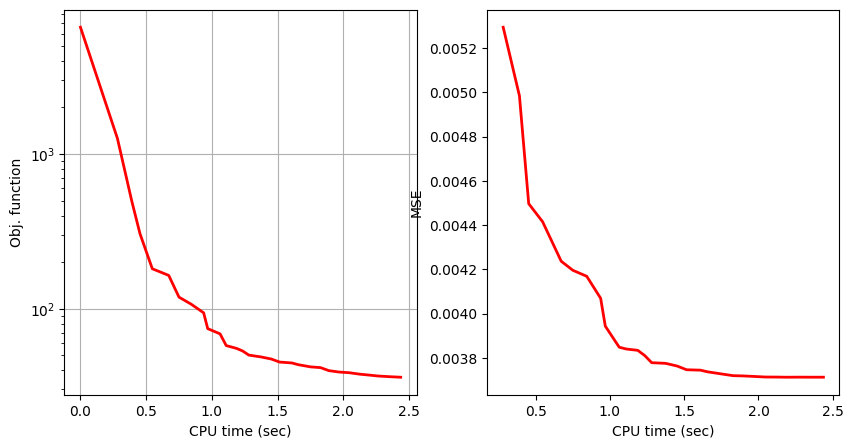

TwIST CPU time: 2.4375
MSE Loss: 3.7129e-03


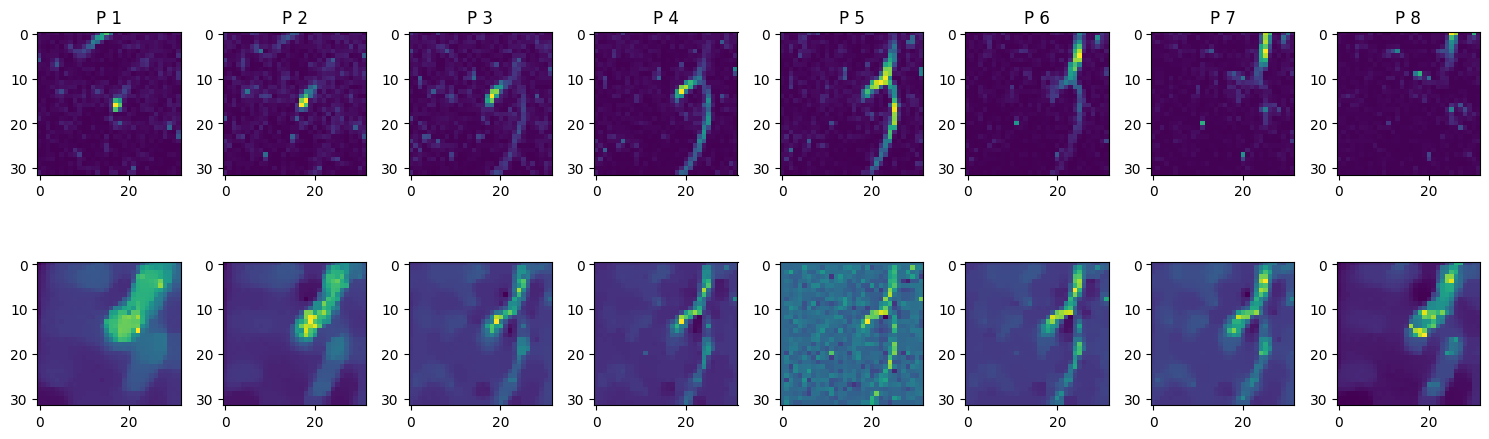

plane 1 | SSIM = 0.0982 | PSNR = 7.6012 dB
plane 2 | SSIM = 0.1980 | PSNR = 11.4849 dB
plane 3 | SSIM = 0.3898 | PSNR = 18.6096 dB
plane 4 | SSIM = 0.3304 | PSNR = 13.7971 dB
plane 5 | SSIM = 0.4316 | PSNR = 21.3873 dB
plane 6 | SSIM = 0.4342 | PSNR = 13.7866 dB
plane 7 | SSIM = 0.3631 | PSNR = 16.9647 dB
plane 8 | SSIM = 0.1957 | PSNR = 12.3870 dB


In [65]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

tau = 1/20 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-2 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))